# DSCI 100 Project Final Report (Group 40) 
> Github: [dsci-100-project](https://github.com/wizexplorer/dsci-100-project)

## Predicting Newsletter Subscription from Player Behaviour

In [1]:
# Load required packages
library(tidyverse)
library(repr)
library(tidymodels)

# set seed for reproducability
set.seed(0)

options(repr.plot.width = 12, repr.plot.height = 8)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

### Introduction

#### Background:
Game companies often use newsletters to keep players engaged with
new content, events, and promotions. However, sending messages
to players who are unlikely to subscribe or interact can waste
marketing effort. If we can predict which players are more likely
to subscribe, the company can target those users more efficiently
and potentially improve engagement and revenue.

#### Research questions:
##### Broad question:
What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter?

##### Specific question:
Can we accurately predict whether a player subscribes to the game-related newsletter based on their characteristics and in-game behavior?   
  
Accuracy metric will not be very useful here because the response class is not balanced.. "TRUE" observations outnumber the "FALSE" once by 3 times (shown later). Hence, we will focus on improving the recall of the model as we believe missing out on potential subscribers (recall) is more costly than targeting uninterested players (precision).   
  (*__TODO__: improve specific question*)


#### Data description:
We use two datasets `players`  and  `sessions`:


__Players dataset__   
The players dataset contains 196 observations of players with 7 attributes:  
  - `experience` (character): Self-reported experience level of the player
  - `subscribe`(logical): Whether player subscribed to the newsletter
  - `hashedEmail` (character): Hashed unique player identifier
  - `played_hours` (double): Total number of hours played by the player
  - `name` (character): Player's chosen in-game name
  - `gender` (character): Player's gender
  - `Age` (double): Player's age in years

At first we see that the data is tidy, but to make it usable for our purposes (classification), we will need to convert the character types to categorical variables (factor):

__Sessions dataset__   
The sessions dataset contains 1535 observations of players' sessions with 5 attributes:  
  - `hashedEmail` (character): Hashed unique player identifier
  - `start_time` (character): Human-readable session start time (format: DD/MM/YYYY HH:MM)
  - `end_time` (character): Human-readable session end time (format: DD/MM/YYYY HH:MM)
  - `original_start_time` (double): Session start time as Unix timestamp (milliseconds)
  - `original_end_time` (double): Session end time as Unix timestamp (milliseconds)

This data is almost tidy! Although, `start_time` and `end_time` could be separated into two variables each, we choose not to do so in this case, because we already have a combined (absolute) version for the times which we can use instead of these variables. Instead, we convert them into datetime objects to compute statistics on the dataset. Also, these variables may be helpful to convert the ineligible Unix time into legible human understandable time later.

From the sessions data, we will derive per-player engagement metrics:
  - `mean_session_duration` (double): average session length in minutes
  - `total_session_duration` (double): total minutes played across sessions
  - `num_sessions` (integer): number of recorded sessions

#### Aim:
Our aim is to build a k-nearest neighbours (k-NN) classifier that predicts subscribe using:   
  Age, experience, gender, played_hours,   
  mean_session_duration, total_session_duration, num_sessions,   
and missingness indicators for the session variables. We will use
5-fold cross-validation to tune k and focus on recall.


### Methododology & Results

In this section we will:
  1) Load and clean the data.
  2) Create derived session features and join to players.
  3) Explore the data with summaries and visualizations.
  4) Build and tune a k-NN model with tidymodels.
  5) Evaluate the final model on a test set.

__1.1 Load the data__

In [8]:
players <- read_csv("https://raw.githubusercontent.com/wizexplorer/dsci-100-project/main/data/players.csv")
sessions <- read_csv("https://raw.githubusercontent.com/wizexplorer/dsci-100-project/main/data/sessions.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
# Quick dimension checks
dim(players)
dim(sessions)

[1] 196   7

[1] 1535    5

__1.2 Clean the data__

In [9]:
players <- players |>
  mutate(
    subscribe = as.factor(subscribe),
    experience = as.factor(experience),
    gender = as.factor(gender)
  )

sessions <- sessions |>
  mutate(
    start_time = dmy_hm(start_time),
    end_time = dmy_hm(end_time),
    session_duration_mins = as.numeric(difftime(end_time, start_time, units = "mins"))
  )

__2.1 Aggregate sessions to player level__   
For each player (hashedEmail) we compute:
  - mean_session_duration
  - total_session_duration
  - num_sessions

In [10]:
session_by_player <- sessions |>
  group_by(hashedEmail) |>
  summarise(
    mean_session_duration = mean(session_duration_mins, na.rm = TRUE),
    total_session_duration = sum(session_duration_mins, na.rm = TRUE),
    num_sessions = n()
  )

__2.2 Join the aggregated sessions data with players dataset__

In [11]:
data <- left_join(x=players, y=session_by_player, by = "hashedEmail")
glimpse(data)

Rows: 196
Columns: 10
$ experience             <fct> Pro, Veteran, Veteran, Amateur, Regular, Amateu…
$ subscribe              <fct> TRUE, TRUE, FALSE, TRUE, TRUE, TRUE, TRUE, FALS…
$ hashedEmail            <chr> "f6daba428a5e19a3d47574858c13550499be23603422e6…
$ played_hours           <dbl> 30.3, 3.8, 0.0, 0.7, 0.1, 0.0, 0.0, 0.0, 0.1, 0…
$ name                   <chr> "Morgan", "Christian", "Blake", "Flora", "Kylie…
$ gender                 <fct> Male, Male, Male, Female, Male, Female, Female,…
$ Age                    <dbl> 9, 17, 17, 21, 21, 17, 19, 21, 47, 22, 23, 17, …
$ mean_session_duration  <dbl> 74.77778, 85.00000, 5.00000, 50.00000, 9.00000,…
$ total_session_duration <dbl> 2019, 255, 5, 50, 9, NA, NA, 5, 13, NA, 115, NA…
$ num_sessions           <int> 27, 3, 1, 1, 1, NA, NA, 1, 1, NA, 3, NA, 1, 1, …


In [12]:
missing_data <- data |>
  summarise(
    n_missing_age = sum(is.na(Age)),
    n_missing_played_hours = sum(is.na(played_hours)),
    n_missing_mean_session = sum(is.na(mean_session_duration)),
    n_missing_total_session = sum(is.na(total_session_duration)),
    n_missing_num_session = sum(is.na(num_sessions))
  )
missing_data

n_missing_age,n_missing_played_hours,n_missing_mean_session,n_missing_total_session,n_missing_num_session
<int>,<int>,<int>,<int>,<int>
2,0,71,71,71


Notice, we have missing data for 71 players from the sessions dataset. Now, 71 observations are a considerable portion of our dataset so we cannot afford the k-nn model removing these rows during training. Consequently, we must somehow make the model include these rows.

We can do this in two ways:
- Impute missing values with either a `0` or `mean` of variable.
- Impute missing values with `0` and create a missing indicator variable to let the model learn if the absence of data carries a signal.

Since we already decided to choose predictive variables using cross validation, we will go with option 2. If the missing data doesn't correspond to a signal, it will automatically have a low accuracy and not be choosen as a pridictive variable.   

We will also impute the 2 missing `Age` observations with its `mean` since this likely does not have a missing information and even if it does, 2 observations might not justify creating an additional column and likely won't affect our accuracy too much.

In [13]:
data <- data |>
  mutate(
    # Create missing indicators (as factors for modeling)
    missing_mean_duration = as.factor(is.na(mean_session_duration)),
    missing_total_duration = as.factor(is.na(total_session_duration)),
    missing_num_sessions   = as.factor(is.na(num_sessions)),

    # Impute missing values with 0 (assumes no session activity)
    mean_session_duration  = replace_na(mean_session_duration, 0),
    total_session_duration = replace_na(total_session_duration, 0),
    num_sessions           = replace_na(num_sessions, 0),

    Age = if_else(
      is.na(Age),
      mean(Age, na.rm = TRUE),
      Age
    )
  )
glimpse(data)

Rows: 196
Columns: 13
$ experience             <fct> Pro, Veteran, Veteran, Amateur, Regular, Amateu…
$ subscribe              <fct> TRUE, TRUE, FALSE, TRUE, TRUE, TRUE, TRUE, FALS…
$ hashedEmail            <chr> "f6daba428a5e19a3d47574858c13550499be23603422e6…
$ played_hours           <dbl> 30.3, 3.8, 0.0, 0.7, 0.1, 0.0, 0.0, 0.0, 0.1, 0…
$ name                   <chr> "Morgan", "Christian", "Blake", "Flora", "Kylie…
$ gender                 <fct> Male, Male, Male, Female, Male, Female, Female,…
$ Age                    <dbl> 9, 17, 17, 21, 21, 17, 19, 21, 47, 22, 23, 17, …
$ mean_session_duration  <dbl> 74.77778, 85.00000, 5.00000, 50.00000, 9.00000,…
$ total_session_duration <dbl> 2019, 255, 5, 50, 9, 0, 0, 5, 13, 0, 115, 0, 10…
$ num_sessions           <int> 27, 3, 1, 1, 1, 0, 0, 1, 1, 0, 3, 0, 1, 1, 0, 0…
$ missing_mean_duration  <fct> FALSE, FALSE, FALSE, FALSE, FALSE, TRUE, TRUE, …
$ missing_total_duration <fct> FALSE, FALSE, FALSE, FALSE, FALSE, TRUE, TRUE, …
$ missing_num_sess

Check if we have solved the missing variable's issue:

In [14]:
missing_data <- data |>
  summarise(
    n_missing_age = sum(is.na(Age)),
    n_missing_played_hours = sum(is.na(played_hours)),
    n_missing_mean_session = sum(is.na(mean_session_duration)),
    n_missing_total_session = sum(is.na(total_session_duration)),
    n_missing_num_session = sum(is.na(num_sessions))
  )
missing_data

n_missing_age,n_missing_played_hours,n_missing_mean_session,n_missing_total_session,n_missing_num_session
<int>,<int>,<int>,<int>,<int>
0,0,0,0,0


__3 Exploratory Data Analysis__

We summarize statistics on the numeric data

In [16]:
summary <- data |>
  group_by(subscribe) |>
  summarise(
    mean_played_hours        = mean(played_hours, na.rm = TRUE),
    mean_age                 = mean(Age, na.rm = TRUE),
    mean_mean_session        = mean(mean_session_duration, na.rm = TRUE),
    mean_total_session       = mean(total_session_duration, na.rm = TRUE),
    mean_num_sessions        = mean(num_sessions, na.rm = TRUE),
    n                        = n(),
    .groups = "drop"
  )

summary

subscribe,mean_played_hours,mean_age,mean_mean_session,mean_total_session,mean_num_sessions,n
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
FALSE,0.5019231,23.75000,16.85472,38.51923,1.980769,52
TRUE,7.7756944,20.19638,22.13525,527.52083,9.944444,144


We also note class balance of the response variable:

In [17]:
data |>
  count(subscribe) |>
  mutate(prop = n / sum(n))

subscribe,n,prop
<fct>,<int>,<dbl>
FALSE,52,0.2653061
TRUE,144,0.7346939


Although the response classes are somewhat imbalanced (26.5% non-subscribers vs 73.5% subscribers), we will not perform re-sampling. 
This is because our primary goal is to correctly identify subscribers (the majority class), so we actually want the model to be generous in predicting TRUE, not to give FALSE extra weight. Upsampling the FALSE or downsampling the TRUE here would mostly protect the non-subscriber class and could reduce recall for TRUE, which is opposite of our goal.

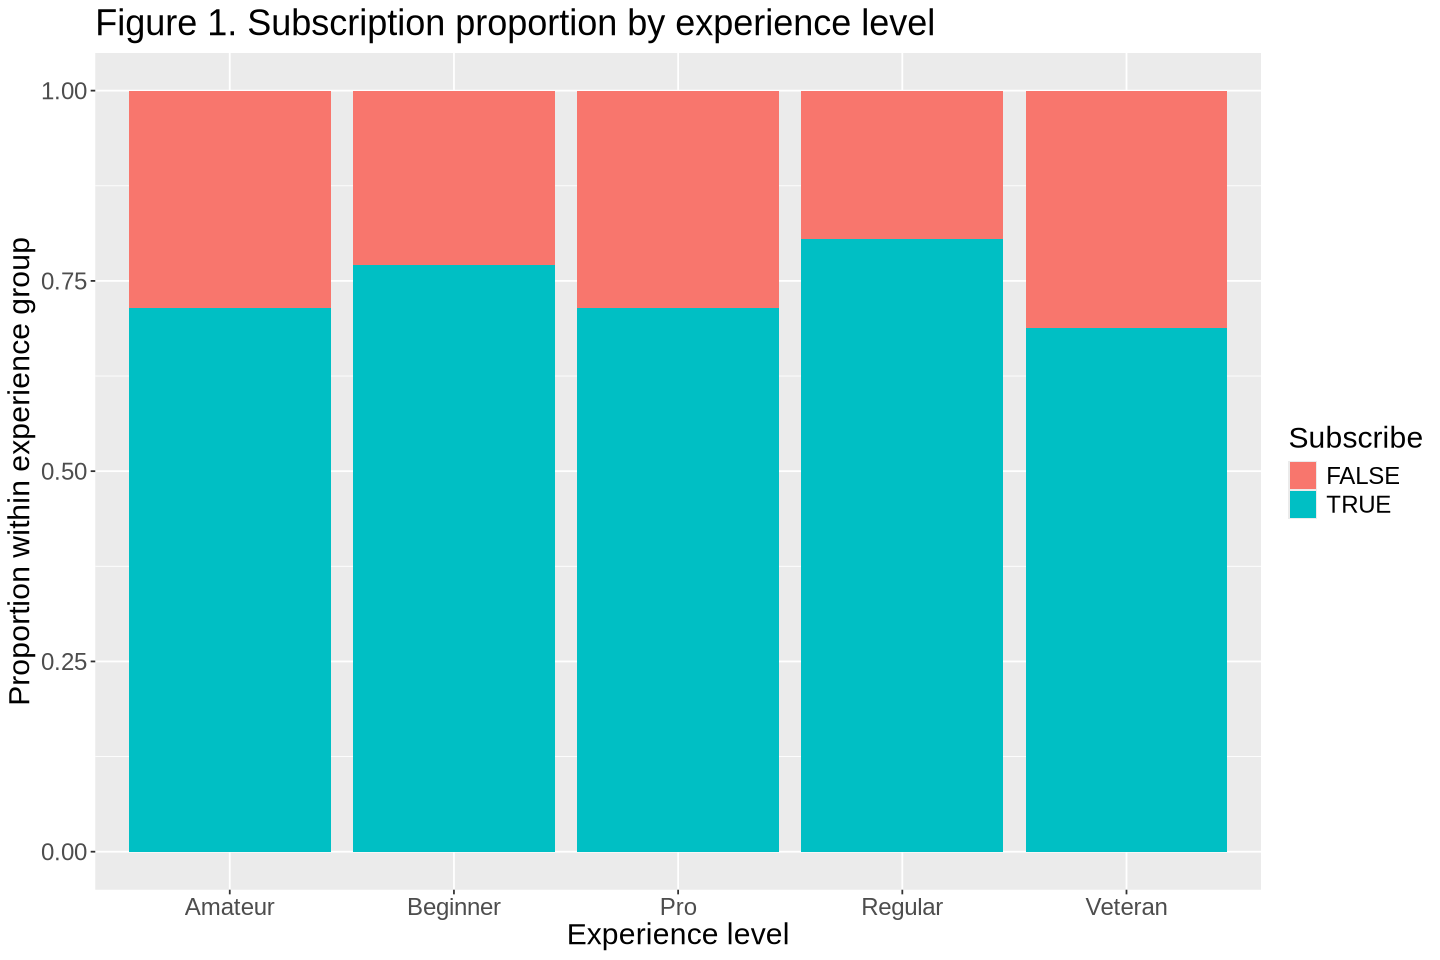

In [22]:
ggplot(data, aes(x = experience, fill = subscribe)) +
  geom_bar(position = "fill") +
  labs(
    title = "Figure 1. Subscription proportion by experience level",
    x = "Experience level",
    y = "Proportion within experience group",
    fill = "Subscribe" 
  ) +
    theme(text = element_text(size=18))

From the summaries and Figure 1, we observe that:
- Players with higher experience levels (Pro, Veteran) appear
  more likely to subscribe than less experienced players.
- Higher played_hours and longer session durations tend to be
  associated with higher subscription rates.
- Ages cluster around early 20s, and players closer to 20
  appear somewhat more likely to subscribe.
These patterns motivate using both demographic and behavioural
predictors in our classification model.